<font size='10'><h1 align="center"><font color='blue'>iPy oxDNA Examples</font></h1>

<center>
<img src="../../../oxDNA.png">
</center>

<font size='10'><a class="anchor" id="3"></a> <h2 align="center"> <font color='black'>Duplex Melting</font></h2> 

In [1]:
from ipy_oxdna.umbrella_sampling import MeltingUmbrellaSampling
from ipy_oxdna.oxdna_simulation import SimulationManager, Simulation, Observable
from ipy_oxdna.vmmc import *

import os
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

<font size='10'><a class="anchor" id="3"></a> <h2 align="center"> <font color='black'>Potential Energy Umbrella Temperature Interpolation</font></h2> 

In [194]:
path = os.path.abspath('/scratch/matthew/ipy_oxDNA/ipy_oxdna_examples/duplex_melting/')

system_name = 'external_force_file'

conditions = ['5']

systems = [f'duplex_52_{stiff}_test' for stiff in conditions]

file_dirs = [f'{path}/{system_name}' for _ in range(len(systems))]


xmin = 0
xmax = 15
n_windows = 56
starting_r0 = 0.4213
stiff = 5
print_every = 1e4
temperature = '52C'
name = 'all_observables.txt'

pre_eq_steps = 1e6
eq_steps = 1e7
prod_steps = 1e9

verlet_skin = 0.5

hb_contact_filename = 'hb_contacts.txt'

com_list = ','.join('8,9,10,11,12,13,14,15'.split(',')[::-1])
ref_list = '0,1,2,3,4,5,6,7'

particle_indexes = [com_list, ref_list]
hb_contact_observable = [{'idx':particle_indexes, 'name':f'{hb_contact_filename}', 'print_every':int(print_every)}]


pre_equlibration_parameters_list = [{'backend':'CPU',"CUDA_list": "no",'use_edge': 'false','steps':f'{pre_eq_steps}','print_energy_every': f'{pre_eq_steps}',
                           'print_conf_interval':f'{pre_eq_steps}', 'refresh_vel': '1',
                           'fix_diffusion': '0', 'T':f'{temperature}', 'verlet_skin': f'{verlet_skin}' }
                            for _ in conditions]

equlibration_parameters_list = [{'backend':'CPU',"CUDA_list": "no",'use_edge': 'false','steps':f'{eq_steps}','print_energy_every': f'{eq_steps}',
                           'print_conf_interval':f'{eq_steps/10}', 'refresh_vel': '1',
                           'fix_diffusion': '0', 'T':f'{temperature}', 'verlet_skin': f'{verlet_skin}'}
                            for _ in conditions]

production_parameters_list = [{'backend':'CPU',"CUDA_list": "no",'use_edge': 'false','steps':f'{prod_steps}','print_energy_every': f'{prod_steps}',
                           'print_conf_interval':f'{prod_steps/10}', 'refresh_vel': '1',
                           'fix_diffusion': '0', 'T':f'{temperature}', 'verlet_skin': f'{verlet_skin}'}
                            for _ in conditions]

us_list = [MeltingUmbrellaSampling(file_dir, sys, clean_build='force') for file_dir, sys in zip(file_dirs,systems)]
simulation_manager = SimulationManager()

In [193]:
for us, pre_equlibration_parameters in zip(us_list, pre_equlibration_parameters_list):
    print(us.system)
    us.build_pre_equlibration_runs(simulation_manager, n_windows, com_list, ref_list,
                               stiff, xmin, xmax, pre_equlibration_parameters, starting_r0, pre_eq_steps,
                               print_every=print_every, observable=True, protein=None,
                               force_file=True, continue_run=False, name=name, custom_observable=hb_contact_observable)

duplex_52_5_test
Build error in simulation /scratch/matthew/ipy_oxDNA/ipy_oxdna_examples/duplex_melting/multi_system_runs/duplex_52_5_test/pre_equlibration/0: list index out of range
Traceback: Traceback (most recent call last):
  File "/scratch/matthew/ipy_oxDNA/ipy_oxdna/umbrella_sampling.py", line 337, in _build_simulation
    sim.add_force_file()
  File "/scratch/matthew/ipy_oxDNA/ipy_oxdna/oxdna_simulation.py", line 97, in add_force_file
    self.build_sim.get_force_file()
  File "/scratch/matthew/ipy_oxDNA/ipy_oxdna/oxdna_simulation.py", line 281, in get_force_file
    force_file = [file for file in files if (file.endswith(('.txt')))][0]
IndexError: list index out of range
Build error in simulation /scratch/matthew/ipy_oxDNA/ipy_oxdna_examples/duplex_melting/multi_system_runs/duplex_52_5_test/pre_equlibration/13: list index out of range
Traceback: Traceback (most recent call last):
  File "/scratch/matthew/ipy_oxDNA/ipy_oxdna/umbrella_sampling.py", line 337, in _build_simulation


AttributeError: 'MeltingUmbrellaSampling' object has no attribute 'equlibration_sims'

In [5]:
#I need to implement a way to modify the force.js to contain group_name, where the group name of the dict is the key of item
#such that I can create objervables which output the force_energy of every individual external potential.

#Once I have done that, I will be able to use the potential energy output to the file all_observables.txt in analysis.
#I will be using a non-parametric potential energy weighting scheme

#by taking summing over the exp(-beta*(U_i - f) for each window, and then dividing by the sum of the exp(-beta*U) for all windows.

In [ ]:
simulation_manager.run(cpu_run=True, gpu_mem_block=False)

In [7]:
for us, equlibration_parameters in zip(us_list, equlibration_parameters_list):
    print(us.system)
    us.build_equlibration_runs(simulation_manager, n_windows, com_list, ref_list,
                               stiff, xmin, xmax, equlibration_parameters, print_every=print_every,
                               observable=True, protein=None, force_file=True, continue_run=False, name=name, custom_observable=hb_contact_observable)

duplex_52_5_test


In [8]:
simulation_manager.run(cpu_run=True, gpu_mem_block=False)

spawning


Running: 0
Running: 1
Running: 2
Running: 3
Running: 4
Running: 5
Running: 6
Running: 7
Running: 8
Running: 9
Running: 10
Running: 11
Running: 12
Running: 13
Running: 14
Running: 15
Running: 16
Running: 17
Running: 18
Running: 19
Running: 20
Running: 21
Running: 22
Running: 23
Running: 24
Running: 25
Running: 26
Running: 27
Running: 28
Running: 29
Running: 30
Running: 31
Running: 32
Running: 33
Running: 34
Running: 35
Running: 36
Running: 37
Running: 38
Running: 39
Running: 40
Running: 41
Running: 42
Running: 43
Running: 44
Running: 45
Running: 46
Running: 47
Running: 48
Running: 49
Running: 50
Running: 51
Running: 52
Running: 53
Running: 54
Running: 55
Run time: 285.720418067649
Finished: 38
Run time: 294.8168027587235
Finished: 26
Run time: 293.5834826808423
Finished: 51
Run time: 295.0466103181243
Finished: 52
Run time: 299.5786978639662
Finished: 17
Run time: 298.3780124280602
Finished: 43
Run time: 297.50005024299026
Finished: 54
Run time: 297.7643867302686
Finished: 55
Run time: 

In [201]:
for us, production_parameters in zip(us_list, production_parameters_list):
    print(us.system)
    us.build_production_runs(simulation_manager, n_windows, com_list, ref_list,
                             stiff, xmin, xmax, production_parameters,
                             observable=True, print_every=print_every ,protein=None,
                             force_file=True, continue_run=1e9, name=name, custom_observable=hb_contact_observable)

duplex_52_5_test


In [202]:
simulation_manager.run(cpu_run=True, gpu_mem_block=False)

spawning


Running: 0
Running: 1
Running: 2
Running: 3
Running: 4
Running: 5
Running: 6
Running: 7
Running: 8
Running: 9
Running: 10
Running: 11
Running: 12
Running: 13
Running: 14
Running: 15
Running: 16
Running: 17
Running: 18
Running: 19
Running: 20
Running: 21
Running: 22
Running: 23
Running: 24
Running: 25
Running: 26
Running: 27
Running: 28
Running: 29
Running: 30
Running: 31
Running: 32
Running: 33
Running: 34
Running: 35
Running: 36
Running: 37
Running: 38
Running: 39
Running: 40
Running: 41
Running: 42
Running: 43
Running: 44
Running: 45
Running: 46
Running: 47
Running: 48
Running: 49
Running: 50
Running: 51
Running: 52
Running: 53
Running: 54
Running: 55


In [5]:
simulation_manager.terminate_all()

In [195]:
for us in us_list:
    us.observables_list = []
    us.initialize_observables(com_list, ref_list, print_every=print_every, name=name)

all_observables = []
for us in us_list:
    all_observables.append(us.analysis.read_all_observables('prod'))

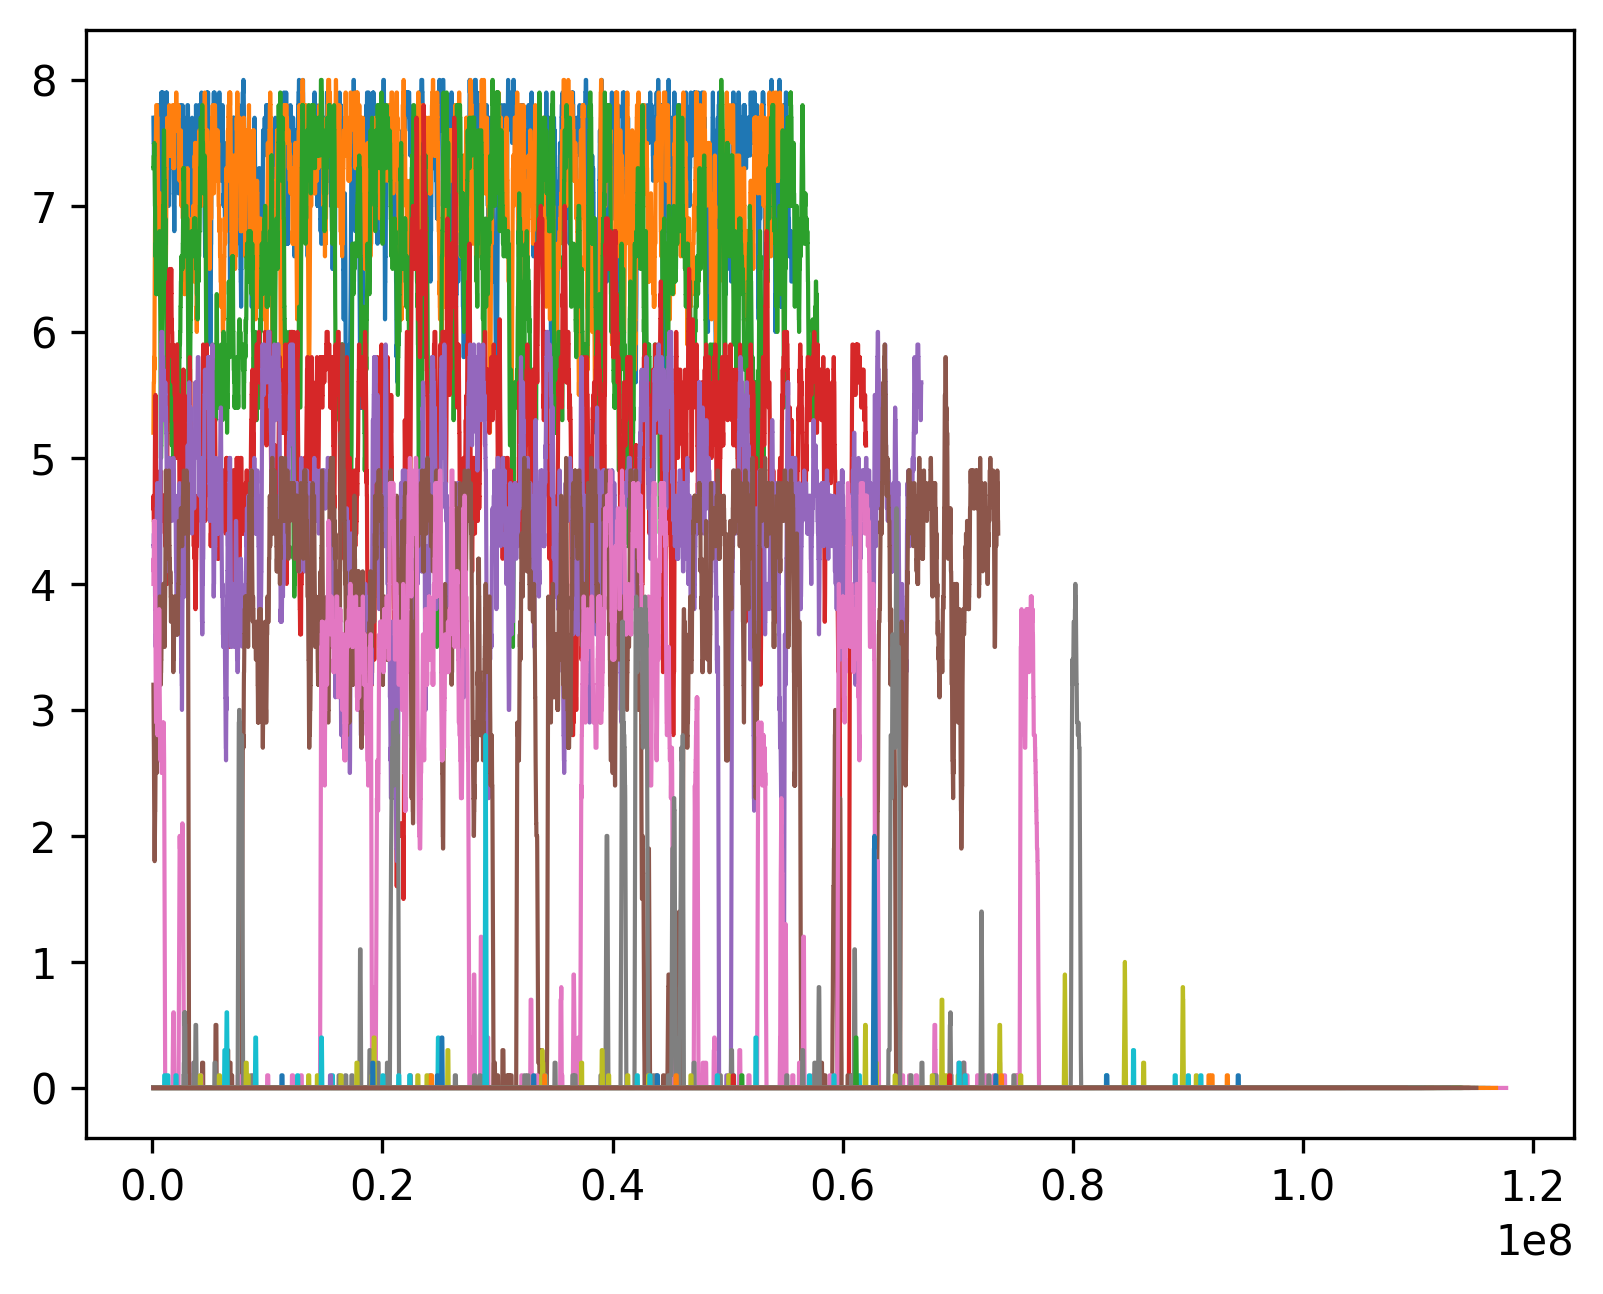

In [197]:
names = ['backbone', 'bonded_excluded_volume', 'stacking', 'nonbonded_excluded_volume', 'hydrogen_bonding', 'cross_stacking', 'coaxial_stacking', 'debye_huckel']
columns = ['com_distance', 'hb_list', 'force_energy', *names]

my_obs = all_observables[0]

fig, ax = plt.subplots(dpi=300)
for idx, obs in enumerate(my_obs):
    plt.plot(obs['steps'], obs['hb_list'].rolling(window=10).mean(), label=f'{idx}', linewidth=1)
# plt.legend(fontsize=1)

In [196]:
xmin = 0
xmax = 15
# temp_range = np.linspace(45, 65, 41)
# temp_range = np.array([52])
temp_range = np.array([20, 30, 40, 45, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 70, 80])
n_bins = 200
max_hb = 8
epsilon = 1e-5
convergence_slice = 1


com_samples, force_samples, f_i_old = us_list[0].weight_sample(temp_range, n_bins, xmin, xmax, max_hb,
                                   epsilon=1e-7, reread_files=False, all_observables=True,
                                   max_iterations=100000, convergence_slice=None)

e_to_neg_u_beta = np.exp(-force_samples.to_numpy() * 16 * beta)
e_to_neg_fi_beta_old = np.exp(-f_i_old * beta)


In [198]:
iterations = 100

convergence_criterion_list = []

for iteration in range(iterations):
    denom = np.sum(e_to_neg_u_beta * (1 / e_to_neg_fi_beta_old), axis=1)

    numerator = 1 / np.sum(1 / denom)

    w_i =  numerator / denom

    e_to_neg_fi_beta_new = np.sum(w_i[:, np.newaxis] * e_to_neg_u_beta, axis=0)
    
    convergence_criterion = np.max(np.abs(e_to_neg_fi_beta_new - e_to_neg_fi_beta_old))
    
    convergence_criterion_list.append(convergence_criterion)
    print(convergence_criterion)    
    e_to_neg_fi_beta_old = deepcopy(e_to_neg_fi_beta_new)


4890785.205511039
0.014808788207473333
0.0004367491713445082
1.2307498276409312e-05
3.467339406704184e-07
9.768003961241334e-09
2.7517799150444944e-10
7.75191022484023e-12
2.1860291354869332e-13
5.88418203051333e-15
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250

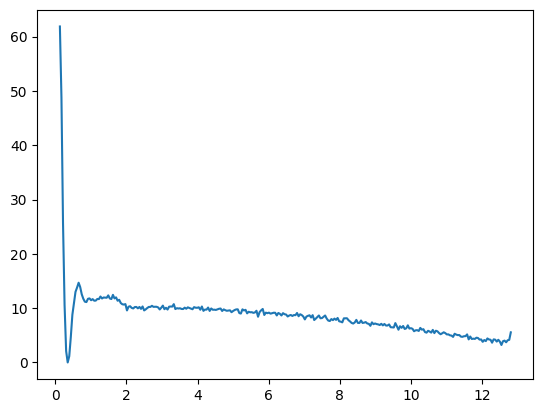

In [200]:

H, bins = np.histogram(com_samples, weights=w_i, bins=300)

free = -np.log(H)
free = free - np.min(free)

plt.plot(bins[1:-10]*0.8518, free[:-10] * beta)

In [92]:
temperature = np.array(us_list[0].temperature, dtype=np.double)
beta = 1 / temperature


iterations = 1000
convergence_criterion = 1

iteration = 0

while convergence_criterion > 1e-15:
    exp_term = np.exp(-beta * force_samples.to_numpy()) * f_i_old
    P_t = np.sum(exp_term, axis=1)
    W_t =  P_t / sum(P_t)


    temp_F_i = W_t[:, np.newaxis] * np.exp(-beta * force_samples.to_numpy())
    F_i = np.sum(temp_F_i, axis=0)
    f_i_new = F_i
    
    convergence_criterion = np.max(np.absolute(f_i_new - f_i_old))
    print(f'Iteration: {iteration}, convergence criterion: {convergence_criterion}')
    iteration += 1
    f_i_old = deepcopy(f_i_new)
    


Iteration: 0, convergence criterion: 3.2902673081224725
Iteration: 1, convergence criterion: 0.0009369262492896491
Iteration: 2, convergence criterion: 2.277851447463064e-07
Iteration: 3, convergence criterion: 5.539224634532047e-11
Iteration: 4, convergence criterion: 1.3433698597964394e-14
Iteration: 5, convergence criterion: 1.1102230246251565e-16


In [57]:
from copy import deepcopy


temperature = np.array(us_list[0].temperature, dtype=np.double)
beta = 1 / temperature

convergence_criterion_list = []

iterations = 10


f_i_old = np.ones_like(list(range(18)))

exp_term = np.exp(-(force_samples.to_numpy() - f_i_old[np.newaxis, :]) * beta)

exp_term_sum = np.sum(exp_term, axis=1)

exp_term_norm =  1 / np.sum(1/exp_term_sum)

w_i = exp_term_norm / exp_term_sum

exp_force = np.exp(-force_samples.to_numpy() * beta)

exp_force_weight = exp_force * w_i[:, np.newaxis]


f_i_new = np.log(sum_term) / -beta

f_i_old = deepcopy(f_i_new)


    


iteration: 9, convergence_criterion: [3.18848757e-06 3.18845802e-06 3.19606373e-06 ... 3.36480599e-06
 3.40012642e-06 3.34536914e-06]


In [46]:
f_i_new

array([0.00200257, 0.00195635, 0.00192352, 0.001906  , 0.00190603,
       0.00192383, 0.00195651, 0.00200303, 0.00200303, 0.00195651,
       0.00192383, 0.00190603, 0.001906  , 0.00192352, 0.00195635,
       0.00200257, 0.00369112, 0.00369112])

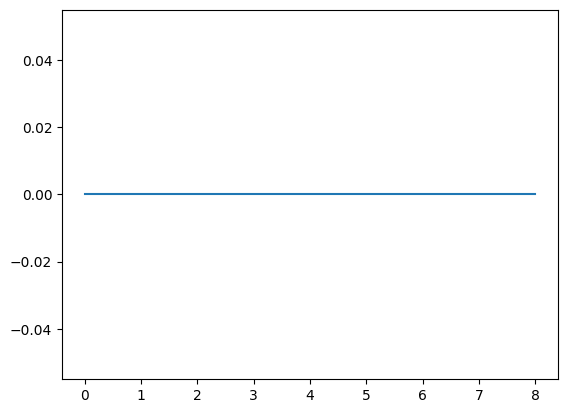

In [42]:
plt.plot(range(iteration), convergence_criterion_list[1:])

In [48]:
exp_term = logsumexp(-(force_samples.to_numpy() - f_i_old[np.newaxis, :]) * beta, axis=1)
exp_term_norm_factor = logsumexp(-(force_samples.to_numpy() - f_i_old[np.newaxis, :]) * beta)
exp_term_normed = exp_term_norm_factor - exp_term
exp_term_final = np.exp(exp_term_normed)

exp_term_final

array([301557.08386471, 301554.28904877, 302273.63794637, ...,
       318232.72436132, 321573.29150077, 316394.38283662])

In [44]:
from copy import deepcopy
from scipy.special import logsumexp



iterations = 1000

for iteration in range(iterations):
    exp_term = logsumexp(-(force_samples.to_numpy() - f_i_old[np.newaxis, :]) * beta, axis=1)
    exp_term_norm_factor = logsumexp(-(force_samples.to_numpy() - f_i_old[np.newaxis, :]) * beta)
    exp_term_normed = exp_term_norm_factor - exp_term
    exp_term_final = np.exp(exp_term_normed)

    exp_neg_beta_f_i = np.sum(np.exp((-force_samples.to_numpy() * beta)) * exp_term_final[:, np.newaxis], axis=0)

    f_i_new = -np.log(exp_neg_beta_f_i)  / beta

    f_i_old = deepcopy(f_i_new)

np.sum(exp_term_final)

KeyboardInterrupt: 

In [46]:
import numpy as np
from tqdm import tqdm
from scipy.special import logsumexp
from copy import deepcopy

# Assuming other relevant variables and functions are defined (us_list, temp_range, etc.)

com_samples, force_samples, f_i_old = us_list[0].weight_sample(temp_range, n_bins, xmin, xmax, max_hb,
                                   epsilon=1e-7, reread_files=False, all_observables=True,
                                   max_iterations=100000, convergence_slice=None)

temperature = np.array(us_list[0].temperature, dtype=np.double)
beta = 1 / temperature

max_iterations = 100000  # Maximum iterations
epsilon = 1e-7  # Convergence criterion
update_frequency = 1000  # Frequency of progress bar updates
significant_digits = abs(int(np.floor(np.log10(abs(epsilon))))) + 1
custom_bar_format = '{desc} {r_bar}'

first = True
iteration = 0

with tqdm(total=max_iterations, desc='Progress', leave=True, bar_format=custom_bar_format) as pbar:
    while (iteration < max_iterations) and ((first is True) or (iteration < 100) or (np.max(np.abs(f_i_new - f_i_old)) > epsilon)):
        exp_term = logsumexp(-(force_samples.to_numpy() - f_i_old[np.newaxis, :]) * beta, axis=1)
        exp_term_norm_factor = logsumexp(-(force_samples.to_numpy() - f_i_old[np.newaxis, :]) * beta)
        exp_term_normed = exp_term - exp_term_norm_factor
        exp_term_final = np.exp(exp_term_normed)

        exp_neg_beta_f_i = np.sum(np.exp((-force_samples.to_numpy() * beta)) * exp_term_final[:, np.newaxis], axis=0)

        f_i_new = -np.log(exp_neg_beta_f_i) / beta

        # Convergence Check
        convergence_criterion = np.max(np.abs(f_i_new - f_i_old))
        formatted_convergence = f"{convergence_criterion:.{significant_digits}f} / {float(epsilon)}"
        pbar.set_postfix_str(f"Convergence: {formatted_convergence}")

        f_i_old = deepcopy(f_i_new)
        iteration += 1

        # Update Progress Bar
        if (iteration % update_frequency == 0) or (iteration == max_iterations) or (first == True):
            pbar.update(update_frequency if not first else 0)
        first = False

np.sum(exp_term_final)  # Final computation


Progress | 0/100000 [00:01<?, ?it/s, Convergence: 0.00000000 / 1e-07]

Progress | 0/100000 [00:14<?, ?it/s, Convergence: 0.00000000 / 1e-07]


1.0000000000000004

(-0.05, 1.05)

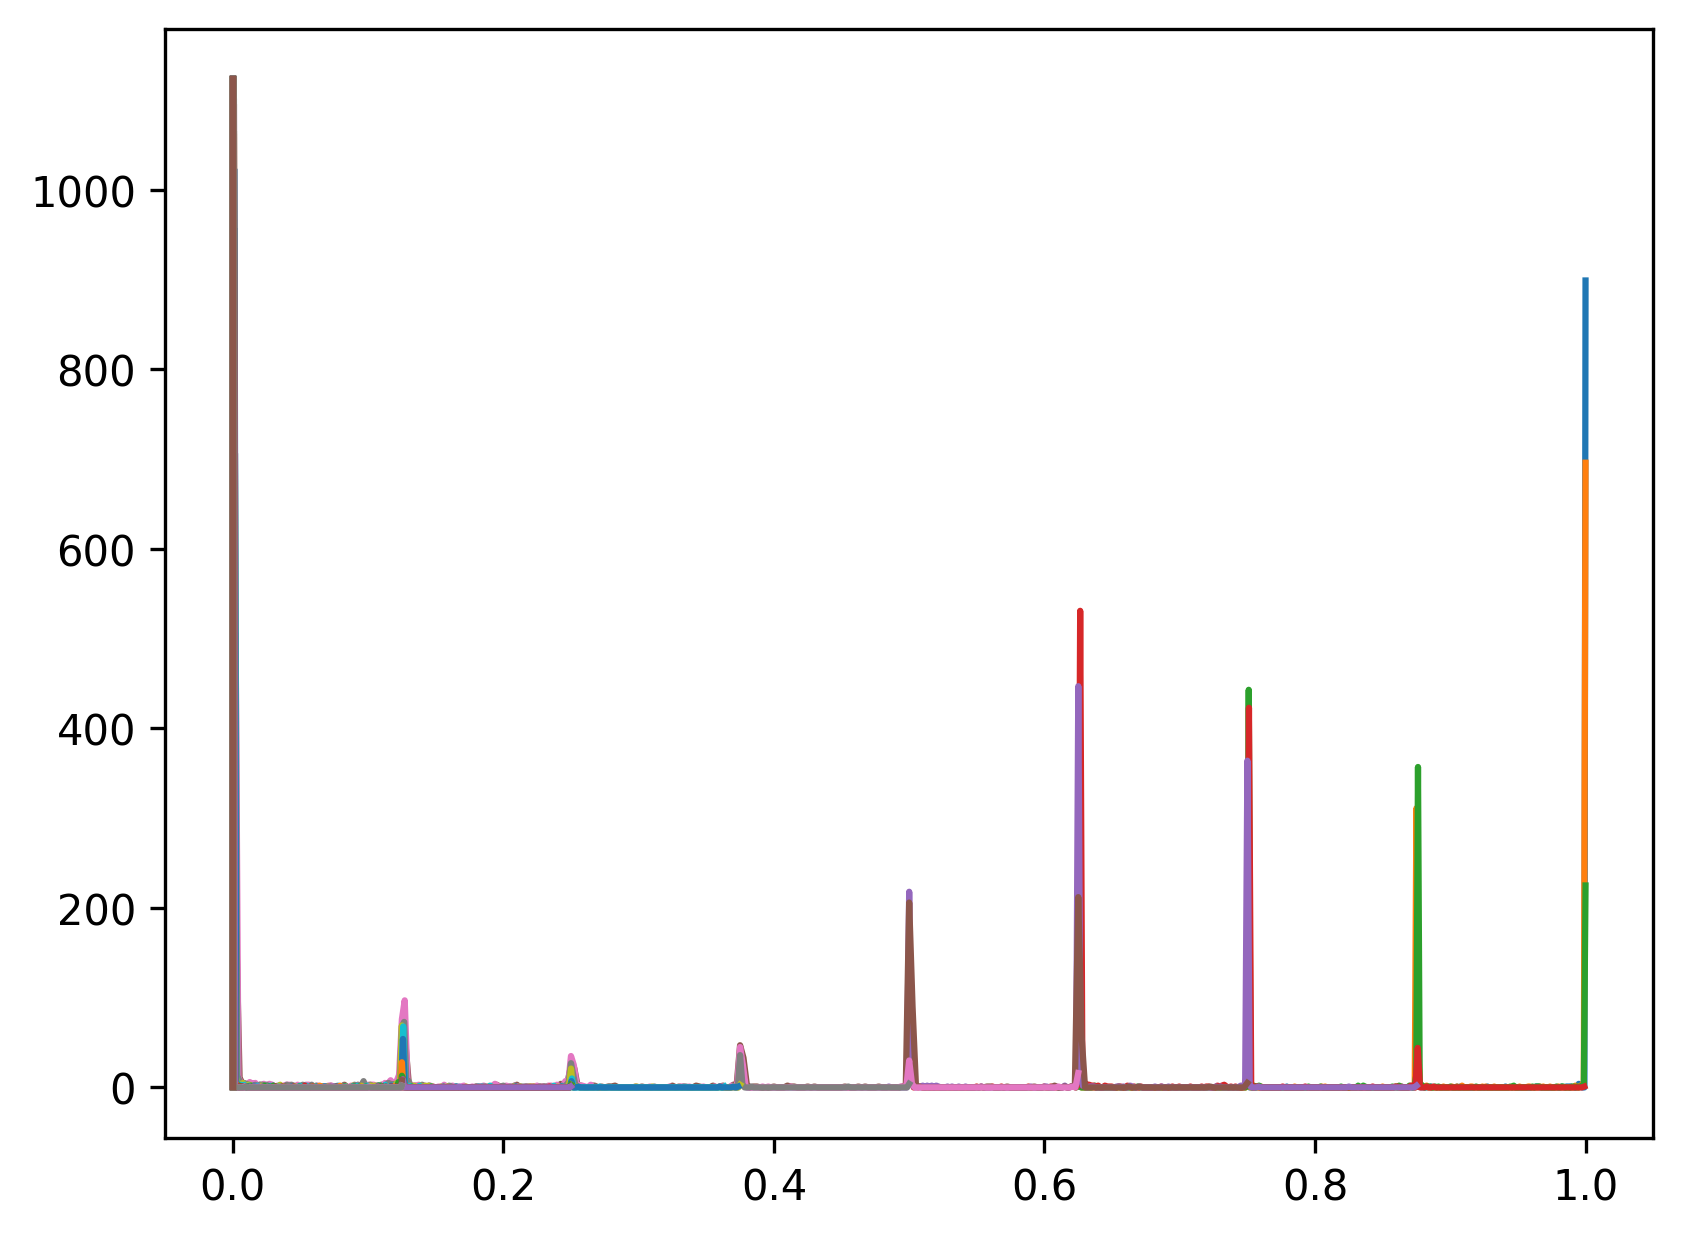

In [10]:
us_list[0].read_hb_contacts(sim_type='prod')

min_len = min([len(inner_list) for inner_list in us_list[0].hb_contacts_by_window.values()])
truncated_hb_contacts_by_window = np.array([value[:min_len] for value in us_list[0].hb_contacts_by_window.values()]).squeeze()

fig, ax = plt.subplots(dpi=300)
for hb_contacts in truncated_hb_contacts_by_window:
    
    H, bins = np.histogram(hb_contacts, bins=300)
    ax.plot(bins[1:], H)
ax.set_xlim(-0.05, 1.05)

In [ ]:
for sim in us_list[0].pre_equlibration_sims[::5]:
    sim.analysis.view_last()

In [23]:
xmin = 0
xmax = 15
# temp_range = np.linspace(45, 65, 41)
# temp_range = np.array([52])
temp_range = np.array([20, 30, 40, 45, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 70, 80])
n_bins = 200
max_hb = 8
epsilon = 1e-5
convergence_slice = 1

us_list[0].wham_cont_and_disc_temp_interp_converg_analysis(convergence_slice, temp_range,
                                                           n_bins, xmin, xmax,max_hb,
                                                           epsilon=epsilon, reread_files=False,
                                                           all_observables=True)

WHAM | 9000/? [01:01<00:00, 146.16it/s, Convergence: 0.000013 / 1e-05]
/scratch/mlsample/ipy_oxDNA/ipy_oxdna/umbrella_sampling.py:1332: RuntimeWarning: divide by zero encountered in log
  free = -np.log(p_x)


Converged in [9644] iterations
64.96993987975952


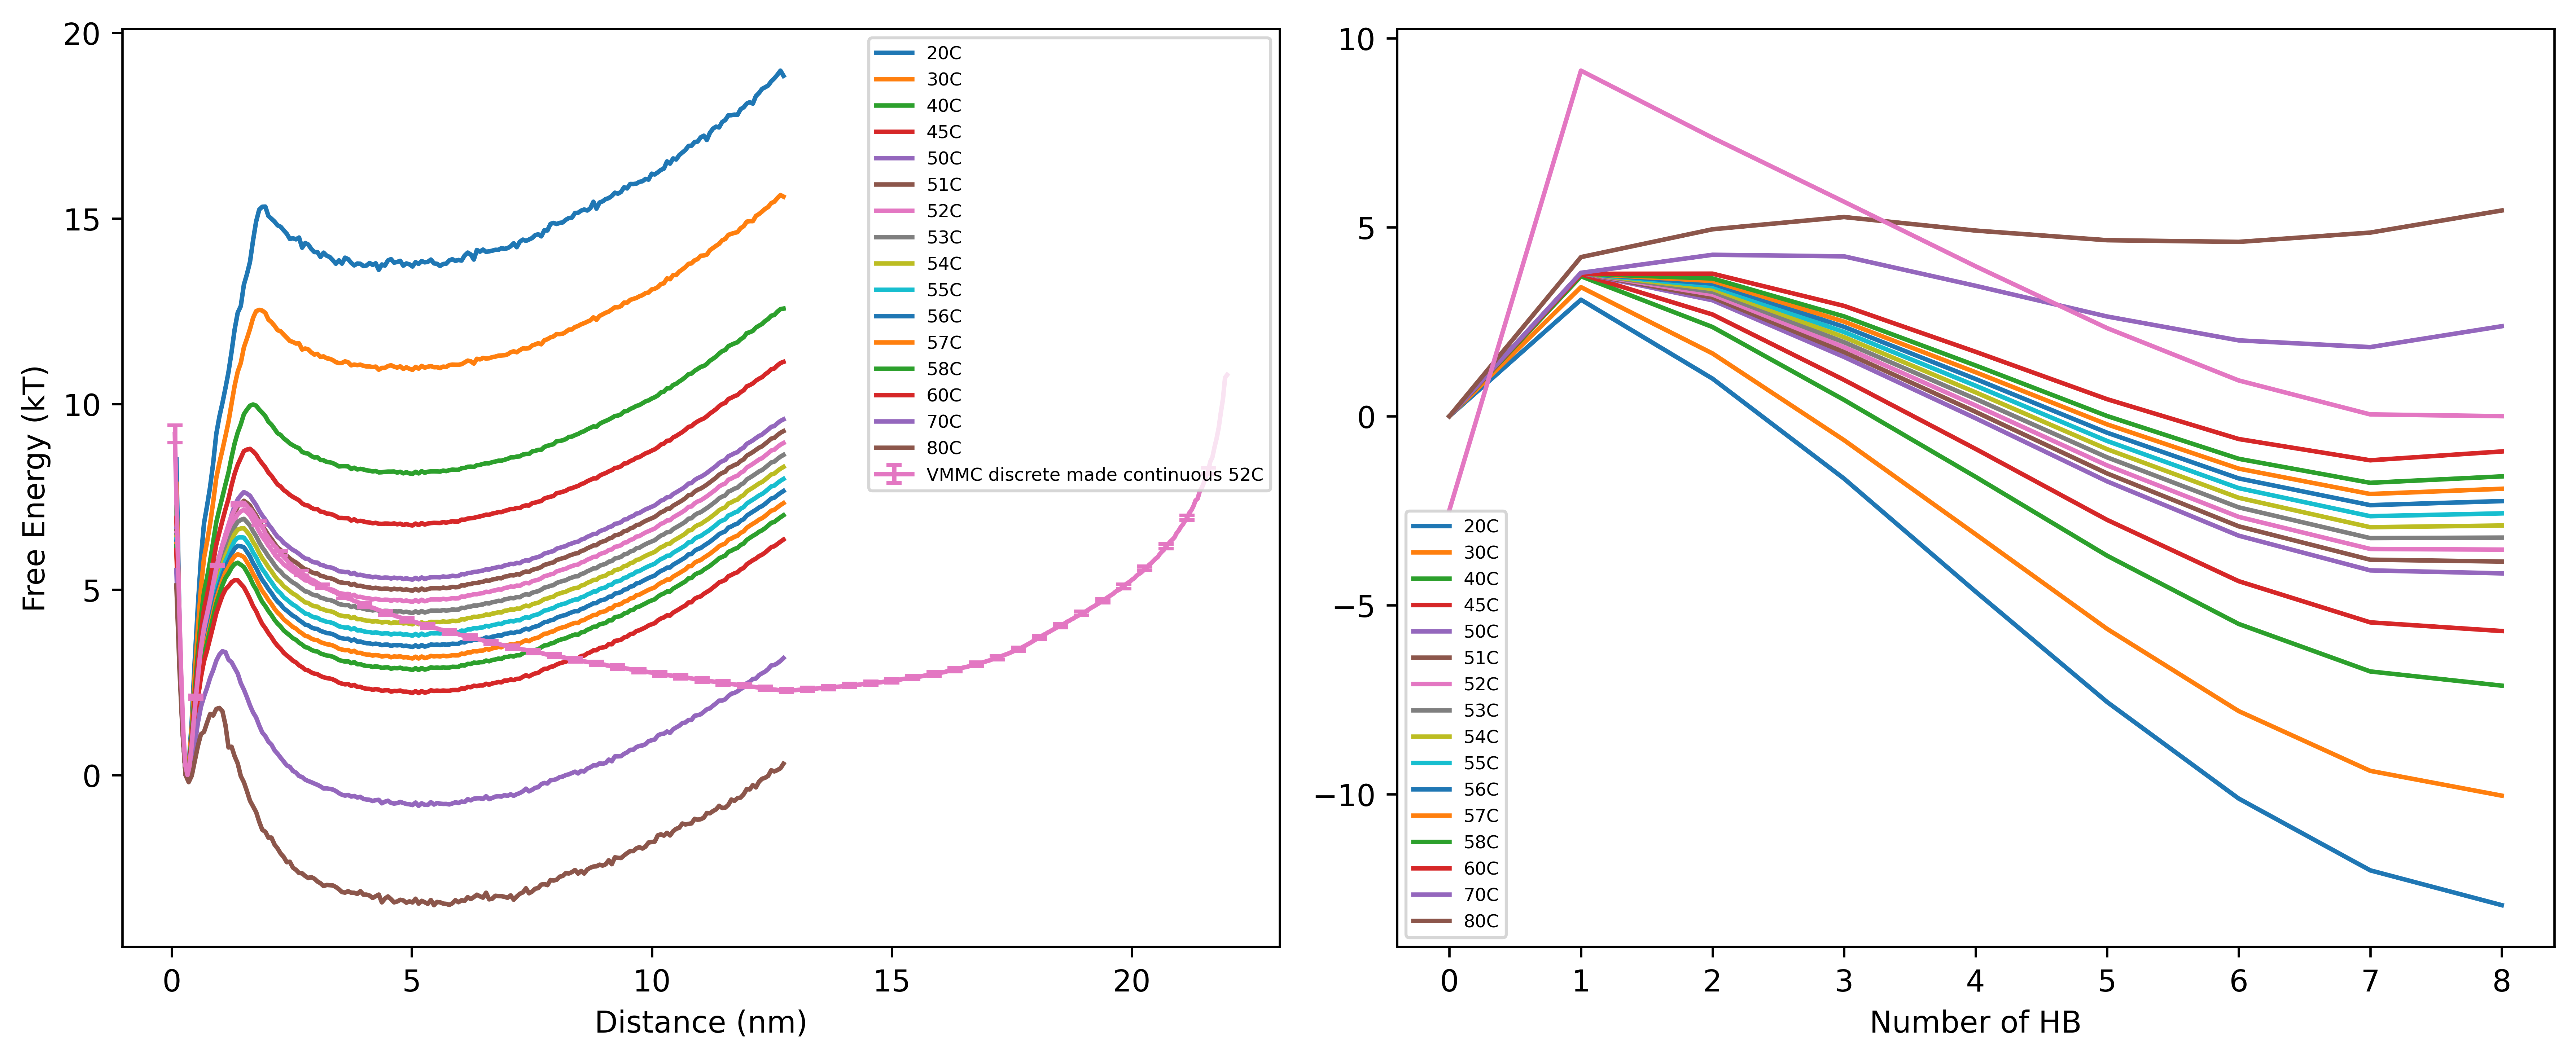

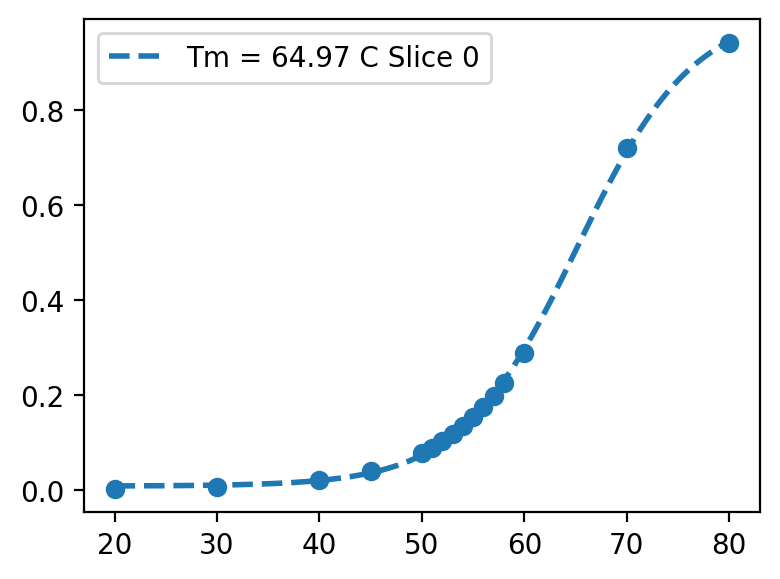

In [24]:
calculated_bin_centers, bin_edges = us_list[0].get_bins(xmin, xmax, n_bins=n_bins)

fig, (ax1, ax2) = plt.subplots(1,2, dpi=600, figsize=(12,5), tight_layout=True)
fig, ax = plt.subplots(dpi=200, figsize=(4,3), tight_layout=True)

ax1.set_xlabel('Distance (nm)')
ax2.set_xlabel('Number of HB')

ax1.set_ylabel('Free Energy (kT)')
# ax2.set_ylabel('Free Energy (kT)')

# ax1.set_xlim(-0.6,14.5)
# ax2.set_xlim(-0.6,29)
# ax1.set_ylim(-0.6,20)

for idx, free in enumerate(us_list[0].convergence_free):            
    sub_index = free[0].argmin()
    for f, temp_val in zip(free, temp_range):
        if idx == 0:
            ax1.plot(calculated_bin_centers*0.8518, f - f[sub_index], label=f'{temp_val}C') 
        else:
            ax1.plot(calculated_bin_centers*0.8518, f - f[sub_index])
vmmc_replica_generator.plot_mean_free_energy_with_error_bars(num_bins=500, ax=ax1, confidence_level=0.95, label='VMMC discrete made continuous 52C')

        
ax1.legend(fontsize=6)


for idx, free_discrete in enumerate(us_list[0].convergence_discrete_free_energy):
    for f_discrete, temp_val in zip(free_discrete, temp_range):
        if idx == 0:
            ax2.plot(range(max_hb+1), f_discrete - f_discrete[0], label=f'{temp_val}C')
        else:
            ax2.plot(range(max_hb+1), f_discrete - f_discrete[0])
ax2.legend(fontsize=6)
ax2.plot(range(9), vmmc_sim_list[0].statistics['wt_free'] - vmmc_sim_list[0].statistics['wt_free'].values[-1])
label = ''

for idx, (inverted_finfs, x_fit, y_fit, Tm) in enumerate(zip(us_list[0].convergence_inverted_finfs, us_list[0].convergence_x_fit, us_list[0].convergence_y_fit, us_list[0].convergence_Tm)):
    ax.scatter(temp_range, inverted_finfs, marker='o')
    ax.plot(x_fit, y_fit, linestyle='--', linewidth=2, label=f'Tm = {Tm:.2f} C Slice {idx}')
    # ax.axvline(x=Tm, color='r', linestyle='--', linewidth=2, label=f'{label}Tm = {Tm:.2f} °C')
    ax.legend()   

In [19]:
wham_dir = os.path.abspath('/scratch/matthew/ipy_oxDNA/wham/wham')
n_bins = '400'
tol = '1e-5'
n_boot = '0'


xmin = [0]
xmax = [15]
n_windows = 56
stiff = 5
print_every = 1e4
temperature = '52C'
name = 'all_observables.txt'

pre_eq_steps = 1e6
eq_steps = 1e8
prod_steps = 1e9

for us in us_list:
    us.observables_list = []
    us.initialize_observables(com_list, ref_list, print_every=print_every, name=name)

for us, xmi, xma  in zip(us_list, xmin, xmax):
    us.wham_run(wham_dir, xmi, xma, stiff, n_bins, tol, n_boot, all_observables=True)
    
n_chunks = 2
data_added_per_iteration = 2

for us, xmi, xma  in zip(us_list, xmin, xmax):
    us.wham.get_n_data_per_com_file()
    us.convergence_analysis(n_chunks, data_added_per_iteration, wham_dir, xmi, xma, stiff, n_bins, tol, n_boot)

Running WHAM analysis...
WHAM analysis completed
[0, 1919, 3838]
Running WHAM analysis...
WHAM analysis completed
Running WHAM analysis...
WHAM analysis completed
chunk convergence analysis
[0, 1919, 3838]
Running WHAM analysis...
WHAM analysis completed
Running WHAM analysis...
WHAM analysis completed
chunk convergence analysis


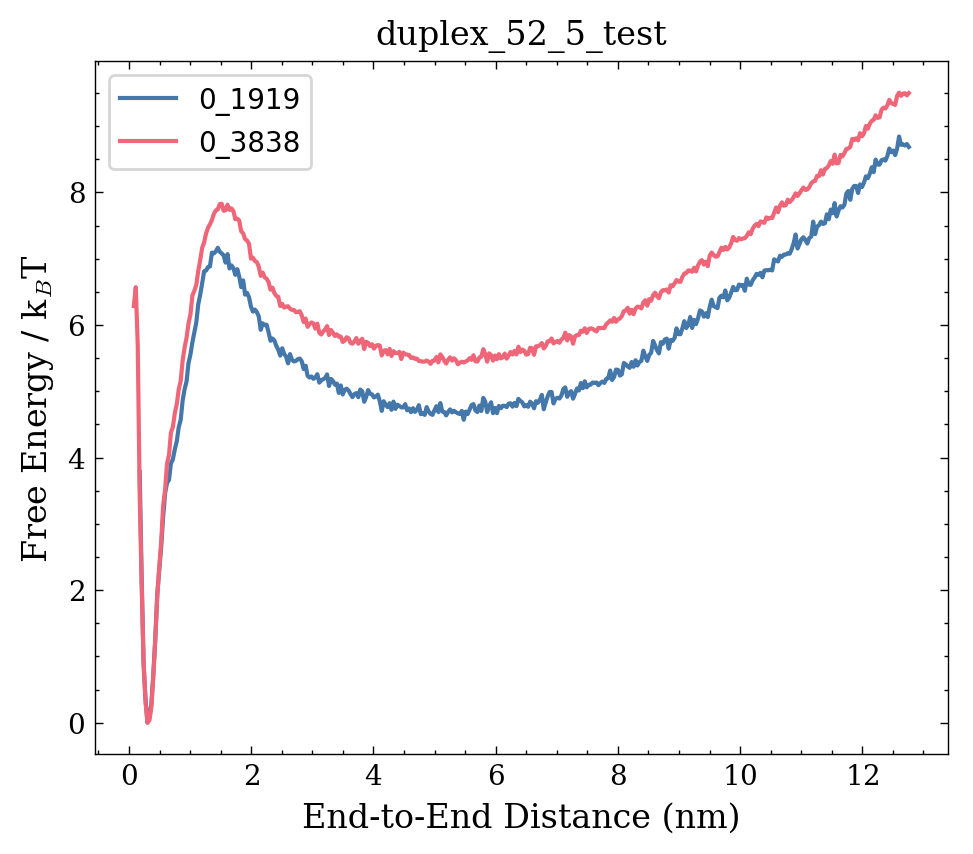

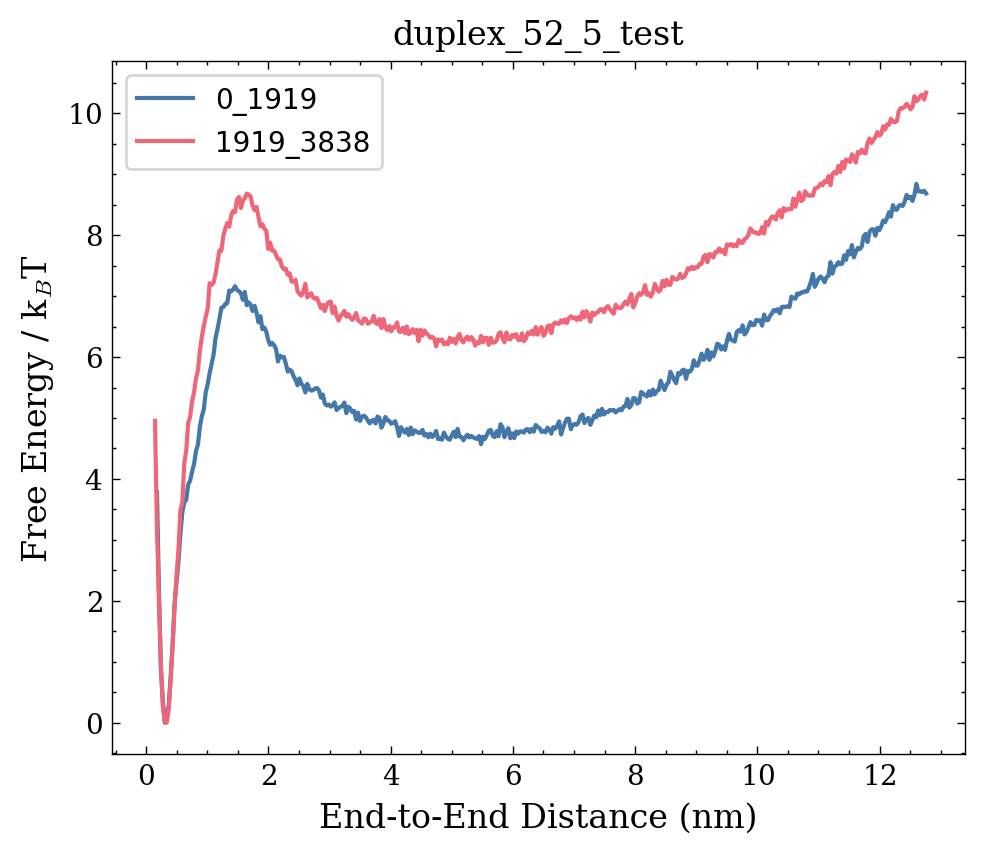

In [20]:
for us in us_list:
    us.wham.plot_truncated_free_energy()
    plt.legend()
    plt.title(us.system)
    us.wham.plot_chunks_free_energy()
    plt.legend()
    plt.title(us.system)

<font size='7'><a class="anchor" id="3"></a> <h2 align="center"> <font color='black'>Initalize Vmmc Replicas</font></h2> 

In [11]:
path = os.path.abspath('/scratch/mlsample/ipy_oxDNA/ipy_oxdna_examples')
systems = ['duplex_melting']

file_dir_list = [f'{path}/{sys}' for sys in systems]
sim_dir_list = [f'{file_dir}/vmmc_melting_replicas/vmmc_melting_rep' for sys, file_dir in zip(systems, file_dir_list)]

n_replicas = 40
vmmc_replica_generator = VmmcReplicas()

vmmc_replica_generator.multisystem_replica(
    systems,
    n_replicas,
    file_dir_list,
    sim_dir_list
)
vmmc_sim_list = vmmc_replica_generator.sim_list
queue_of_simulations = vmmc_replica_generator.queue_of_sims

p1 = '15,14,13,12,11,10,9,8'
p2 = '0,1,2,3,4,5,6,7'
pre_defined_weights = [8, 16204, 1882.94, 359.746, 52.5898, 15.0591, 7.21252, 2.2498, 2.89783]

sim_parameters = {'T':'52C', 'steps':'1e9','print_energy_every': '1e5','print_conf_interval':'1e6'}

In [12]:
vmmc_replica_generatoranalysis.read_vmmc_op_data()
vmmc_sim_list[0].analysis.calculate_sampling_and_probabilities()


In [ ]:
vmmc_replica_generator

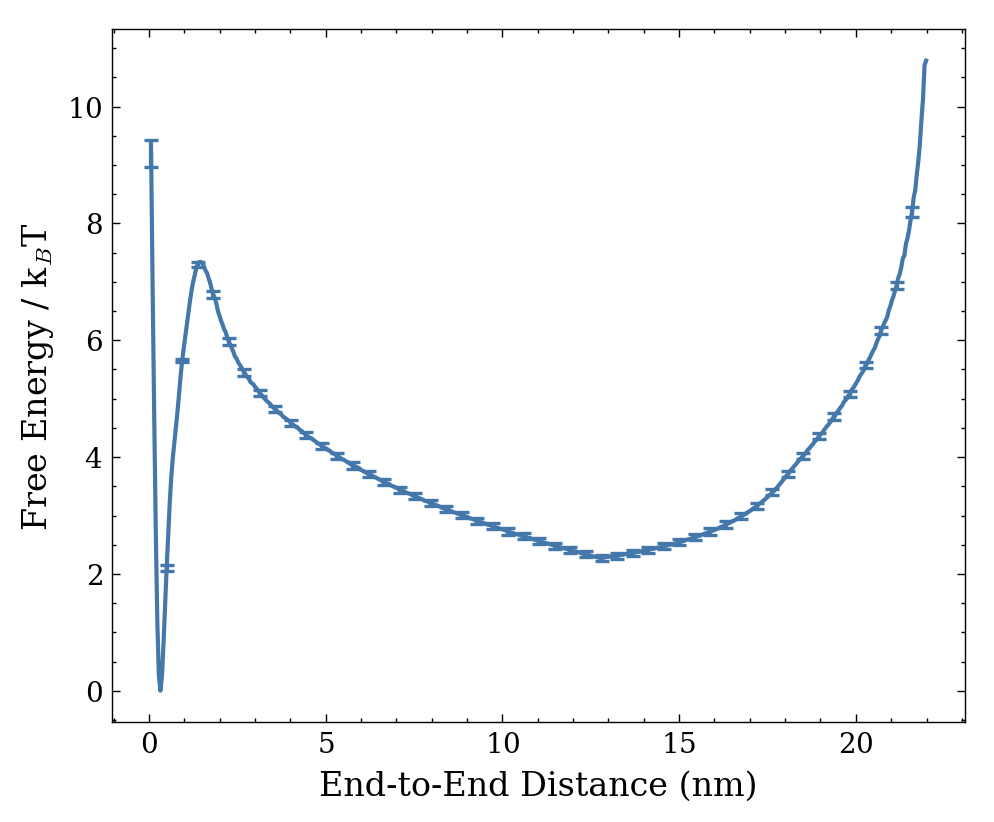

In [14]:
ax = us_list[0].wham.plt_fig()
vmmc_replica_generator.plot_mean_free_energy_with_error_bars(num_bins=500, ax=ax, confidence_level=0.95, label='VMMC discrete made continuous 52C')


In [ ]:
with plt.style.context(['science', 'no-latex', 'bright']):
    ax = us.wham.plt_fig() 
    vmmc_replica_generator.plot_mean_free_energy_with_error_bars(num_bins=500, ax=ax, confidence_level=0.95, label='VMMC discrete made continuous 52C')
    # us_1.wham.plot_free_energy(confidence_level=0.99, ax=ax, errorevery=10, label='Continuous umbrella sampling 52C all bonds')
    us.wham.plot_free_energy(confidence_level=0.99, ax=ax, errorevery=10, label='Continuos umbrella sampling 52C only intended bonds')
    ax.set_xlim(-0.1,8)
    plt.ylim(-0.1,9)
plt.legend(fontsize=6)

In [ ]:
with plt.style.context(['science', 'no-latex', 'bright']):
    ax = us.wham.plt_fig() 
    # vmmc_replica_generator.plot_mean_free_energy_with_error_bars(num_bins=500, ax=ax, confidence_level=0.95, label='VMMC discrete made continuous 52C')
    us_1.wham.plot_free_energy(confidence_level=0.99, ax=ax, errorevery=10, label='Continuous umbrella sampling 52C all bonds')
    us.wham.plot_free_energy(confidence_level=0.99, ax=ax, errorevery=10, label='Continuos umbrella sampling 52C only intended bonds')
    # ax.set_xlim(-0.1,8)
    # plt.ylim(-0.1,9)
plt.legend(fontsize=6)